# Solving the SWE using NN

In [44]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import time
import h5py


## Load data

In [36]:
s = 15

# Initialize an empty list to store the loaded data
t_mesh_all = []
h_all = []
mu_all = []

# Loop to load the .mat files from data_sigma_no1.mat to data_sigma_no10.mat
for i in range(1, s):
    # Construct the filename dynamically
    filename = f'dataFNO/data_sigma_no1mu_no{i}.mat'
    
    # Load the .mat file
    mat_data = scipy.io.loadmat(filename)
    
    # Print the name of the loaded file
    print(f'Loaded: {filename}')
    
    # Store the loaded data in the list
    x_mesh = mat_data['x'].flatten()
    t_mesh_all.append(mat_data['time_all'])
    h_all.append(np.real(mat_data['h_all'][1:,:]))
    mu_all.append(mat_data['mu'])

# Now all_data contains the loaded data from all files


Loaded: dataFNO/data_sigma_no1mu_no1.mat
Loaded: dataFNO/data_sigma_no1mu_no2.mat
Loaded: dataFNO/data_sigma_no1mu_no3.mat
Loaded: dataFNO/data_sigma_no1mu_no4.mat
Loaded: dataFNO/data_sigma_no1mu_no5.mat
Loaded: dataFNO/data_sigma_no1mu_no6.mat
Loaded: dataFNO/data_sigma_no1mu_no7.mat
Loaded: dataFNO/data_sigma_no1mu_no8.mat
Loaded: dataFNO/data_sigma_no1mu_no9.mat
Loaded: dataFNO/data_sigma_no1mu_no10.mat
Loaded: dataFNO/data_sigma_no1mu_no11.mat
Loaded: dataFNO/data_sigma_no1mu_no12.mat
Loaded: dataFNO/data_sigma_no1mu_no13.mat
Loaded: dataFNO/data_sigma_no1mu_no14.mat


In [37]:
mu_all

[array([[0.3]]),
 array([[0.32631579]]),
 array([[0.35263158]]),
 array([[0.37894737]]),
 array([[0.40526316]]),
 array([[0.43157895]]),
 array([[0.45789474]]),
 array([[0.48421053]]),
 array([[0.51052632]]),
 array([[0.53684211]]),
 array([[0.56315789]]),
 array([[0.58947368]]),
 array([[0.61578947]]),
 array([[0.64210526]])]

In [59]:
# Load data
#with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\data_sigma_no1mu_no1.h5', 'r') as file:
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\swe1d_data_gauss_middle.h5', 'r') as file:
    for key in file.keys():
        print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_all'])
    u_all = np.array(file['data_0']['u_all'])
    x = np.array(file['data_0']['x'])
    time_all = np.array(file['data_0']['time_all'])
    sigma = np.array(file['data_0']['sigma'])
    print(f"'h_all' loaded with shape: {h_all.shape}")
    print(f"'u_all' loaded with shape: {u_all.shape}")
    print(f"'x' loaded with shape: {x.shape}")
    print(f"'time_all' loaded with shape: {time_all.shape}")


Key: data_0
  'data_0' is a group containing:
    h0
    h_all
    sigma
    time_all
    u_all
    x
'h_all' loaded with shape: (305, 100)
'u_all' loaded with shape: (305, 100)
'x' loaded with shape: (1, 100)
'time_all' loaded with shape: (304, 1)


In [61]:
h_all.shape, u_all.shape, x.shape, time_all.shape

((305, 100), (305, 100), (1, 100), (304, 1))

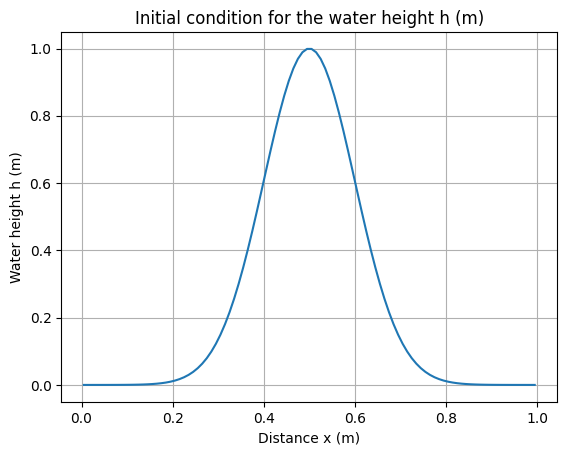

In [58]:
if 1:
    # Plot the initial condition
    plt.figure()
    plt.plot(x.squeeze(), h_all[0,:])
    plt.xlabel('Distance x (m)')
    plt.ylabel('Water height h (m)')
    plt.title('Initial condition for the water height h (m)')
    plt.grid()

    if 0:
        plt.savefig('plots/NN_initial_1D.pdf', format='pdf')

    plt.show()


In [358]:
h_all[0].shape
#t_mesh_all[0].shape

(730, 200)

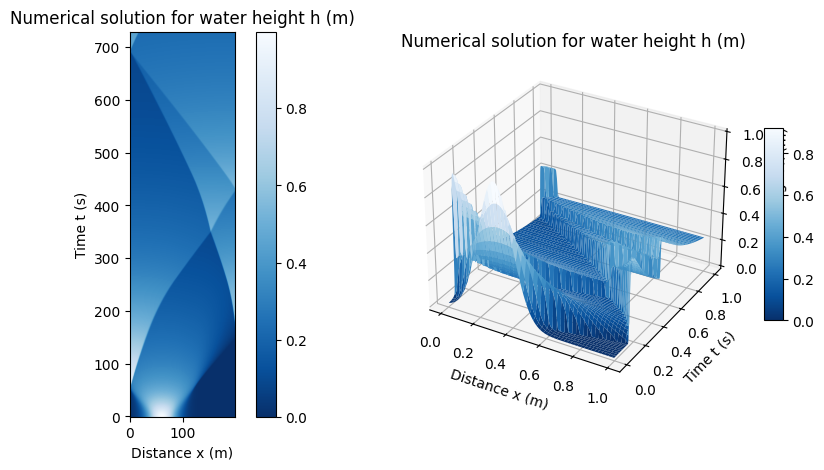

In [360]:
save = 0

cmap = 'Blues_r'

idx = 0

# Plot the data in x,t space
fig = plt.figure(figsize=(12, 5))
  
ax0 = fig.add_subplot(121)
#img = ax0.imshow(h_all[idx], extent=[x_mesh[0], x_mesh[-1], t_mesh_all[idx][-1], t_mesh_all[idx][0]], aspect='auto', cmap=cmap)
img = ax0.imshow(h_all[idx], cmap=cmap)
plt.colorbar(img, ax=ax0)
ax0.set_title('Numerical solution for water height h (m)')
ax0.set_xlabel('Distance x (m)')
ax0.set_ylabel('Time t (s)')
ax0.invert_yaxis()

# Plot in 3D
X, T = np.meshgrid(x_mesh, t_mesh_all[idx])
ax1 = fig.add_subplot(122, projection='3d')
surf1 = ax1.plot_surface(X, T, h_all[idx], cmap=cmap)
ax1.set_title('Numerical solution for water height h (m)')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Time t (s)')
ax1.set_zlabel('Water height h (m)')
fig.colorbar(surf1, ax=ax1, shrink = 0.5, aspect=10)

if save:
    plt.savefig('plots/NN_initial.pdf', format='pdf')

plt.show()


### Function: prepare_data

In [178]:
def prepare_data(h_all, p_train, p_val):

    timesteps, _ = h_all.shape

    # Input a
    a = h_all[:-1]

    # Target u
    u = h_all[1:]

    # Split data into training, validation and test sets
    n_train = int(p_train * timesteps)
    n_val = int(p_val * timesteps)
    n_test = timesteps - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    # Define input and target training sets, validation sets and test sets
    train_x = torch.tensor(a[:n_train], dtype=torch.float32)
    train_y = torch.tensor(u[:n_train], dtype=torch.float32)

    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)

    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)

    x = torch.tensor(a, dtype=torch.float32)
    y = torch.tensor(u, dtype=torch.float32)

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y


In [238]:
def prepare_combined_data(h_all, p_train_last=0.7, p_val_last=0.15):
    # Initialize lists for training, validation, and test data
    train_x_list, train_y_list = [], []
    val_x_list, val_y_list = [], []
    test_x_list, test_y_list = [], []
    x_list, y_list = [], []

    # Process each case in h_all
    for i, h in enumerate(h_all):
        h_array = np.array(h)  # Convert to NumPy array if necessary
        if i < len(h_all) - 1:  # For the first slices, use 100% training
            n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_array, 1.0, 0.0)
        else:  # For the last case, use specified split proportions
            n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_array, p_train_last, p_val_last)

        # Append results to lists
        train_x_list.append(train_x)
        train_y_list.append(train_y)
        if val_x.shape[0] > 0:  # Only add validation data if it exists
            val_x_list.append(val_x)
            val_y_list.append(val_y)
        if test_x.shape[0] > 0:  # Only add test data if it exists
            test_x_list.append(test_x)
            test_y_list.append(test_y)
        
    # Collect the x and y data for the last case
    x_list.append(x)
    y_list.append(y)
            
    # Concatenate lists into tensors
    train_x_combined = torch.cat(train_x_list, dim=0)
    train_y_combined = torch.cat(train_y_list, dim=0)
    val_x_combined = torch.cat(val_x_list, dim=0) if val_x_list else torch.empty(0)
    val_y_combined = torch.cat(val_y_list, dim=0) if val_y_list else torch.empty(0)
    test_x_combined = torch.cat(test_x_list, dim=0) if test_x_list else torch.empty(0)
    test_y_combined = torch.cat(test_y_list, dim=0) if test_y_list else torch.empty(0)
    x_combined = torch.cat(x_list, dim=0)
    y_combined = torch.cat(y_list, dim=0)

    return train_x_combined, train_y_combined, val_x_combined, val_y_combined, test_x_combined, test_y_combined, x_combined, y_combined

In [41]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Solve the SWE using NN

### (ii) RNN Flowmap

In [361]:
save = 0

In [362]:
# Define model
class RNNFlowmap(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(RNNFlowmap, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last hidden state for prediction
        return out
    
input_size = 200
hidden_size = 128
output_size = 200
batch_size = 32

# Instantiate the model
model = RNNFlowmap(input_size, hidden_size, output_size)
print(model)

RNNFlowmap(
  (rnn): RNN(200, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=200, bias=True)
  )
)


In [370]:
train_x, train_y, val_x, val_y, test_x, test_y, x, y = prepare_combined_data(h_all, p_train_last=0.7, p_val_last=0.2)

print("Training data:", train_x.shape, train_y.shape)
print("Validation data:", val_x.shape, val_y.shape)
print("Test data:", test_x.shape, test_y.shape)

dataset_train = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset_train, batch_size, shuffle=True)

dataset_val = torch.utils.data.TensorDataset(val_x, val_y)
val_loader = DataLoader(dataset_val, batch_size, shuffle=True)

n_train = 510, n_val = 146, n_test = 74
Training data: torch.Size([510, 200]) torch.Size([510, 200])
Validation data: torch.Size([146, 200]) torch.Size([146, 200])
Test data: torch.Size([73, 200]) torch.Size([73, 200])


In [371]:
# Prepare data in sequences
def prepare_data_sequences(x, y, seq_length):
    timesteps, spatial_steps = x.shape

    # Number of sequences
    n_sequences = timesteps - seq_length

    # Prepare input and target sequences
    x_seq = torch.zeros((n_sequences, seq_length, spatial_steps))
    y_seq = torch.zeros((n_sequences, spatial_steps))

    for i in range(n_sequences):
        x_seq[i] = x[i:i + seq_length]
        y_seq[i] = y[i + seq_length]
    
    return x_seq, y_seq

In [372]:
seq_length = 10

X_input, X_output = prepare_data_sequences(train_x, train_y, seq_length)
print(X_input.shape, X_output.shape)
X_input_val, X_output_val = prepare_data_sequences(val_x, val_y, seq_length)

batch_size = 32

# Create a dataloader for training and validation data
train_dataset = torch.utils.data.TensorDataset(X_input, X_output)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_input_val, X_output_val)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)


torch.Size([500, 10, 200]) torch.Size([500, 200])


In [373]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_train = []
loss_val = []

# Time training
start_time = time.time()

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = criterion(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Validation loss
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for val_X, val_y in val_loader:
            val_predictions = model(val_X)
            val_loss = criterion(val_predictions, val_y)
            epoch_val_loss += val_loss.item() * val_X.size(0)

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{n_epochs}, Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}")

# Time training
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Epoch 10/100, Training loss: 0.000370, Validation loss: 0.006313
Epoch 20/100, Training loss: 0.000382, Validation loss: 0.006255
Epoch 30/100, Training loss: 0.000295, Validation loss: 0.006658
Epoch 40/100, Training loss: 0.000273, Validation loss: 0.006169
Epoch 50/100, Training loss: 0.000266, Validation loss: 0.006422
Epoch 60/100, Training loss: 0.000234, Validation loss: 0.006632
Epoch 70/100, Training loss: 0.000270, Validation loss: 0.006487
Epoch 80/100, Training loss: 0.001533, Validation loss: 0.005486
Epoch 90/100, Training loss: 0.000925, Validation loss: 0.005836
Epoch 100/100, Training loss: 0.000764, Validation loss: 0.005466
Training time: 31.01s


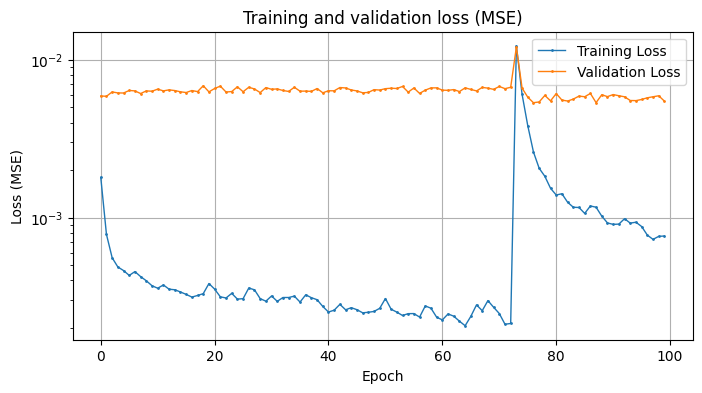

In [374]:
# Plot loss
plt.figure(figsize=(8, 4))
plt.semilogy(loss_train, '.-', label='Training Loss', linewidth=1, markersize=2)
plt.semilogy(loss_val, '.-', label='Validation Loss', linewidth=1, markersize=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and validation loss (MSE)')
plt.legend()
plt.grid()

if save:
    plt.savefig('plots/NN_loss_train_val.pdf', format='pdf')

plt.show()

In [375]:
X_all, Y_all = prepare_data_sequences(x, y, seq_length=10)

# Predictions
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation 
    predictions = model(X_all)  # Full dataset
    test_loss = criterion(predictions, Y_all)
    print(f"Loss: {test_loss.item():.2e}")

Loss: 1.97e-03


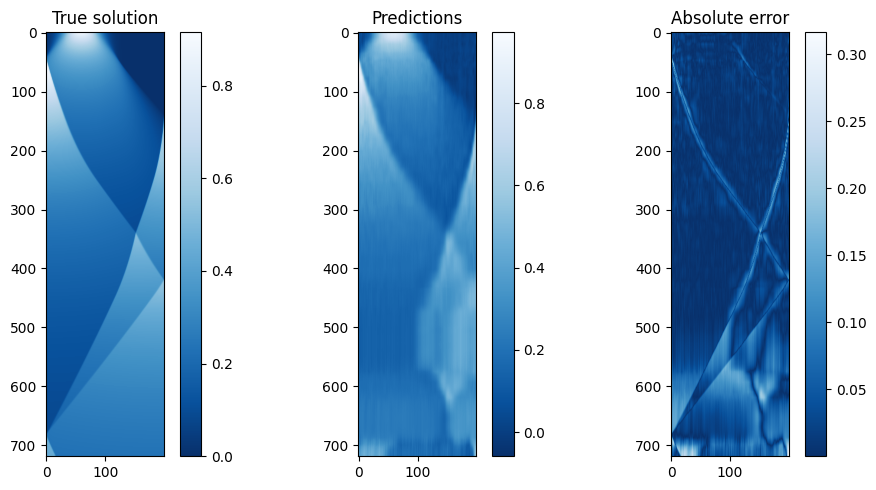

In [376]:
# Plot the output, predictions and absolute error
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(Y_all.numpy(), cmap=cmap)
plt.colorbar()
plt.title('True solution')

plt.subplot(1, 3, 2)
plt.imshow(predictions.numpy(), cmap=cmap)
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(Y_all.numpy() - predictions.numpy()), cmap=cmap)
plt.colorbar()
plt.title('Absolute error')

plt.tight_layout()

plt.show()

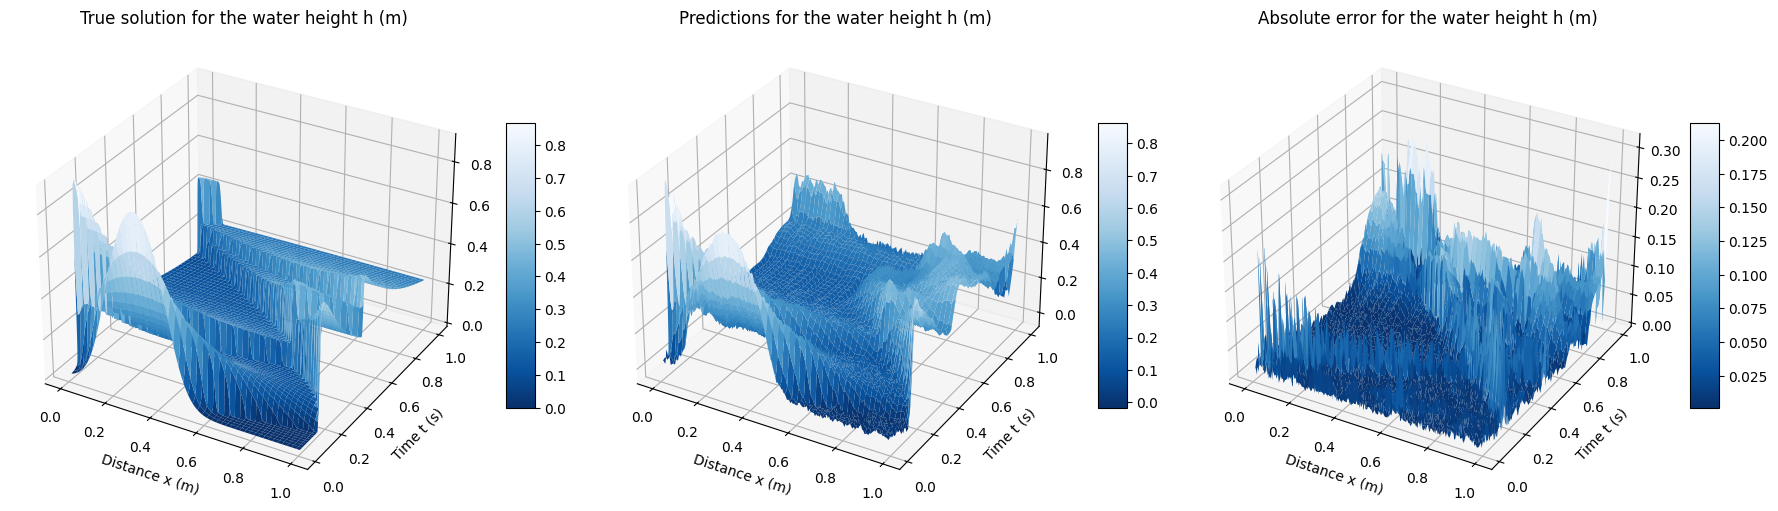

In [377]:
# Prepare grid
X, T = np.meshgrid(x_mesh, t_mesh_all[-1][seq_length+1:])

# Plot the output, predictions and absolute error
fig = plt.figure(figsize=(18, 6))

cmap = 'Blues_r'

# Plot in 3d
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, T, Y_all.numpy(), cmap=cmap)
ax1.set_title('True solution for the water height h (m)')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Time t (s)')
fig.colorbar(surf1, ax=ax1, shrink = 0.5, aspect=10)

ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, T, predictions.numpy(), cmap=cmap)
ax2.set_title('Predictions for the water height h (m)')
ax2.set_xlabel('Distance x (m)')
ax2.set_ylabel('Time t (s)')
fig.colorbar(surf2, ax=ax2, shrink = 0.5, aspect=10)

ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X, T, np.abs(Y_all.numpy() - predictions.numpy()), cmap=cmap)
ax3.set_title('Absolute error for the water height h (m)')
ax3.set_xlabel('Distance x (m)')
ax3.set_ylabel('Time t (s)')
fig.colorbar(surf3, ax=ax3, shrink = 0.5, aspect=10)

plt.tight_layout()

if save:
    plt.savefig('plots/NN_predictions.pdf', format='pdf')

plt.show()

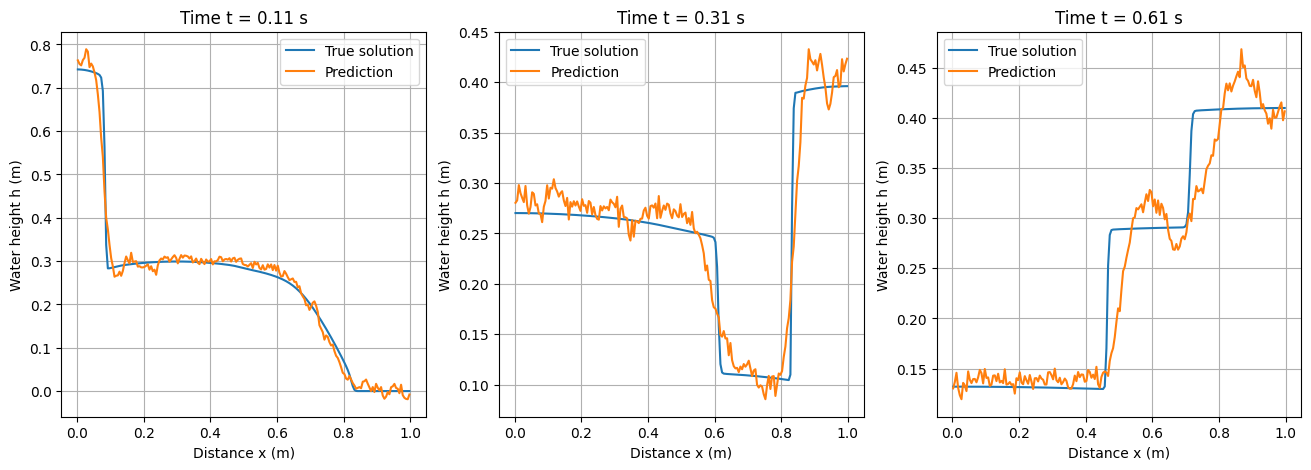

In [378]:
# Plot for some given time steps
indices = [100, 300, 500]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.plot(x_mesh, Y_all[idx].numpy(), label='True solution')
    ax.plot(x_mesh, predictions[idx].numpy(), label='Prediction')
    ax.set_title(f"Time t = {t_mesh[idx]:.2f} s")
    ax.set_xlabel('Distance x (m)')
    ax.set_ylabel('Water height h (m)')
    ax.grid()
    ax.legend()

if save:
    plt.savefig('plots/NN_predictions_time_steps.pdf', format='pdf')

plt.show()

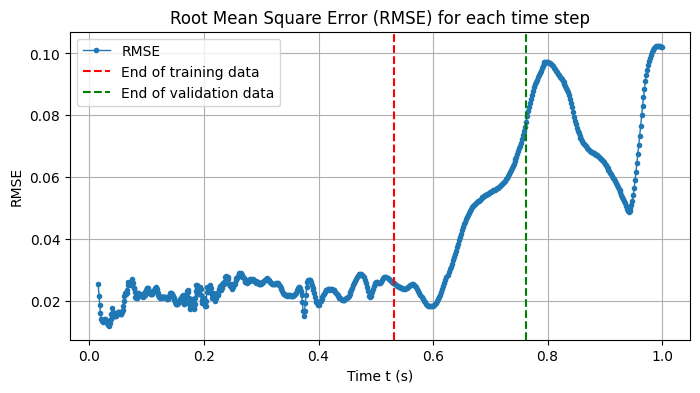

In [379]:
# Plot the RMSE for each time step
rmse = torch.sqrt(torch.mean((Y_all - predictions)**2, dim=1))

plt.figure(figsize=(8, 4))
plt.plot(t_mesh_all[-1][seq_length+1:], rmse.numpy(),'.-', label='RMSE', linewidth=1)
plt.xlabel('Time t (s)')
plt.ylabel('RMSE')
plt.title('Root Mean Square Error (RMSE) for each time step')
plt.grid()
plt.axvline(x=t_mesh[n_train], color='r', linestyle='--', label='End of training data')
plt.axvline(x=t_mesh[n_train+n_val], color='g', linestyle='--', label='End of validation data')
plt.legend()

if save:
    plt.savefig('plots/NN_RMSE.pdf', format='pdf')

plt.show()
